<h1>Predictive Modeling of Renewable Energy Generation Using Time Series and Regression A</h1>


## Problem Context
The amount of wind energy generated, as renewable energy, is a function of the wind speed and direction. As wind speed and direction are periodic (daily, monthly, or seasonal periodicity) variables, wind energy can be considered a time series. In this project, I am attempting to forecast wind power using the available data.
## Question Statements
1. Can we predict how much wind power/energy we can generate in a particular period?

<h2>Table of contents</h2>


1. [About the data](#about_data)
2. [Data analysis/pre-processing](#preprocessing)
3. [Modeling](#modeling)
4. [Evaluation](#evaluation)
5. [Result and Insights](#results)
6. [Conclusions](#conclusions)


<h2 id="about_data">
  About the data
</h2>

Importing the required libraries:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use(['seaborn-v0_8-colorblind'])
%matplotlib inline
import scipy.optimize as opt
from sklearn import preprocessing
import pylab as pl
import sqlite3
import seaborn as sns
import math
import xgboost as xgb

<h3>Data source</h3>

- The dataset is publicly available on Kaggle ([Link](https://www.kaggle.com/datasets/theforcecoder/wind-power-forcasting)).
- It has 13 months of wind-mill turbine data, recorded at 10-min intervals.

<h3>Data Loading</h3>

In [145]:
#reading the data and keeping the index as the date and time

data = pd.read_csv('Turbine_Data.csv', parse_dates=['Unnamed: 0'], index_col=['Unnamed: 0'])
data.index = pd.to_datetime(data.index)

<h2 id="preprocessing">
  Data analysis/pre-processing
</h2>

<h3> Data Wrangling/EDA</h3>

In [146]:
data.head()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,...,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
2017-12-31 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN


In [147]:
#dropping all duplicates

data.drop_duplicates(inplace=True)

In [148]:
data.shape

(95185, 21)

As shown above, 21 attributes: 20 features field and 1 target field.

In [149]:
# finding out the number of unique observations per attribute.
data.nunique()

ActivePower                     94084
AmbientTemperatue               93678
BearingShaftTemperature         62286
Blade1PitchAngle                38946
Blade2PitchAngle                39021
Blade3PitchAngle                39021
ControlBoxTemperature               1
GearboxBearingTemperature       62313
GearboxOilTemperature           62412
GeneratorRPM                    61074
GeneratorWinding1Temperature    62406
GeneratorWinding2Temperature    62424
HubTemperature                  38119
MainBoxTemperature              49145
NacellePosition                  6664
ReactivePower                   94040
RotorRPM                        59254
TurbineStatus                     353
WTG                                 1
WindDirection                    6664
WindSpeed                       94224
dtype: int64

In [150]:
#dropping columns not in time series format

data.drop(columns=["ControlBoxTemperature","WTG"], axis=0, inplace=True)

In [151]:
data.shape

(95185, 19)

In [152]:
data.describe(include="all")

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
count,94624.000000,93698.000000,62380.000000,41987.000000,41882.000000,41882.000000,62402.000000,62430.000000,62287.000000,62419.000000,62441.000000,62268.000000,62369.000000,72108.000000,94622.000000,62119.000000,6.275900e+04,72108.000000,94469.000000
mean,619.036994,28.777569,43.105338,9.751759,10.038709,10.038709,64.376222,57.561706,1102.146658,72.462897,71.829134,36.979752,39.635107,196.307894,88.070309,9.908585,2.284016e+03,196.307894,5.879193
std,610.917748,4.358470,5.168850,20.646533,20.272100,20.272100,10.020754,6.324124,527.967896,22.626685,22.649494,4.884101,5.428555,88.279316,116.498176,4.717546,3.590288e+05,88.279316,2.617241
min,-38.524659,0.000000,0.000000,-43.156734,-26.443415,-26.443415,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-203.182591,0.000000,0.000000e+00,0.000000,0.000000
25%,80.098952,25.625603,39.856871,-0.939896,-0.433316,-0.433316,57.925129,53.944023,1029.812895,55.492241,54.763998,33.977709,35.843574,145.000000,-0.433723,9.231097,2.000000e+00,145.000000,3.824572
50%,402.880706,28.338961,42.927465,0.395038,0.889782,0.889782,64.862406,57.197064,1124.930500,65.792061,65.006679,37.003815,39.500759,182.000000,35.938526,10.099272,2.000000e+00,182.000000,5.558520
75%,1073.979105,31.665910,47.018075,8.101939,8.481306,8.481306,71.104401,61.307270,1515.517020,85.874609,85.342714,40.009538,43.370342,271.000000,147.190453,13.600908,2.000000e+00,271.000000,7.505555
max,1779.032433,42.405597,55.088655,90.143610,90.017830,90.017830,82.237932,70.764581,1809.941700,126.773031,126.043018,47.996185,54.250000,357.000000,403.713620,16.273495,6.574653e+07,357.000000,22.970893


There are some rows with negative Active power, which is incorrect.

In [153]:
#dropping the data points with negative Active Power
data = data[data["ActivePower"] >= 0]
data.shape

(78989, 19)

In [154]:
#checking the null values

data.isnull().sum()

ActivePower                         0
AmbientTemperatue                1032
BearingShaftTemperature         26821
Blade1PitchAngle                43282
Blade2PitchAngle                43365
Blade3PitchAngle                43365
GearboxBearingTemperature       26819
GearboxOilTemperature           26806
GeneratorRPM                    26810
GeneratorWinding1Temperature    26792
GeneratorWinding2Temperature    26785
HubTemperature                  26930
MainBoxTemperature              26841
NacellePosition                 20429
ReactivePower                      42
RotorRPM                        26816
TurbineStatus                   26466
WindDirection                   20429
WindSpeed                         308
dtype: int64

There are too many missing values to simply drop columns. To properly manage them, i'll be visualizing the data first.

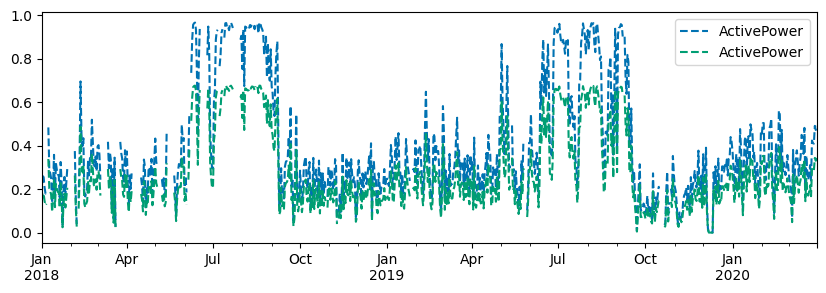

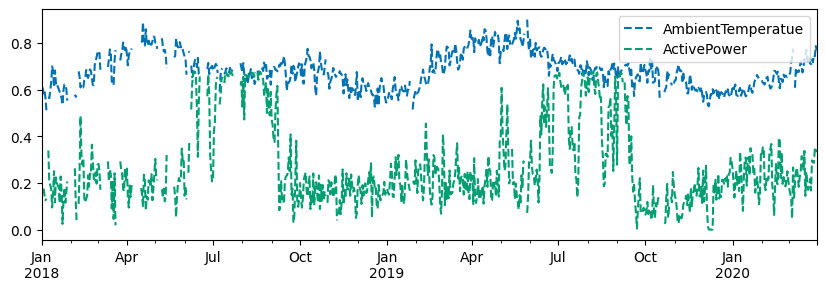

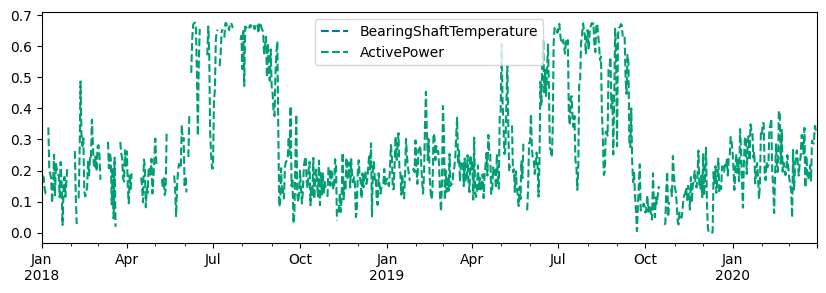

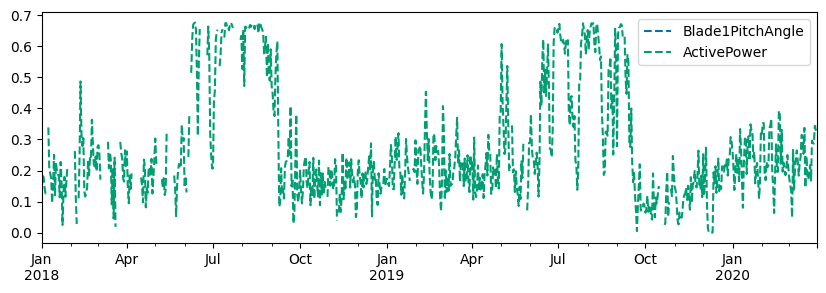

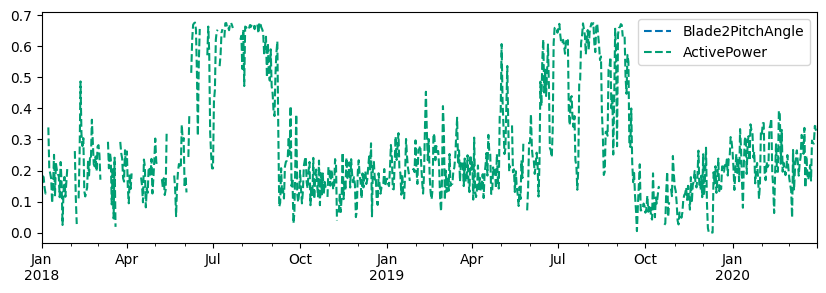

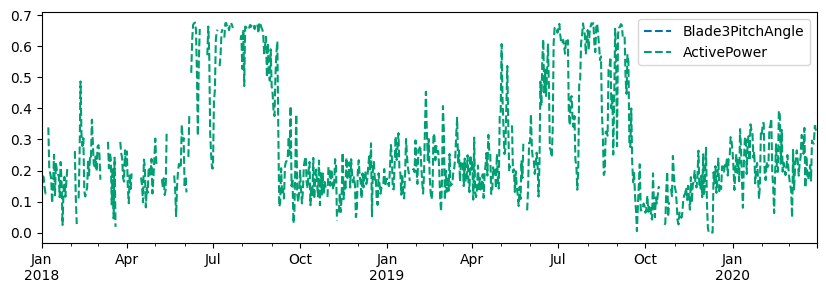

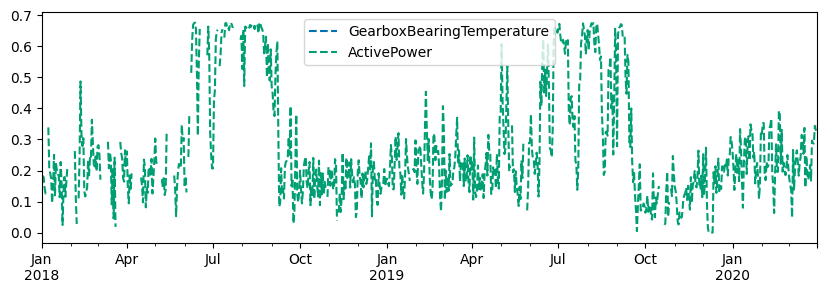

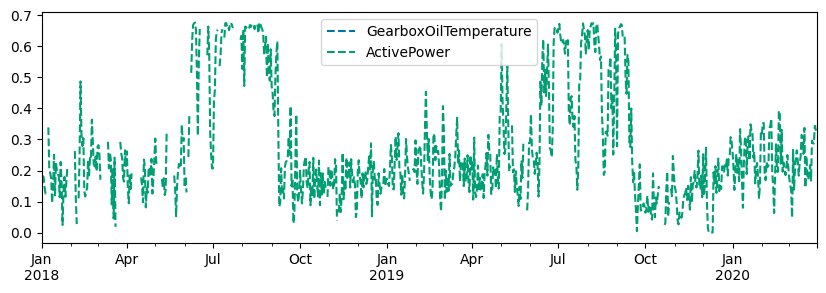

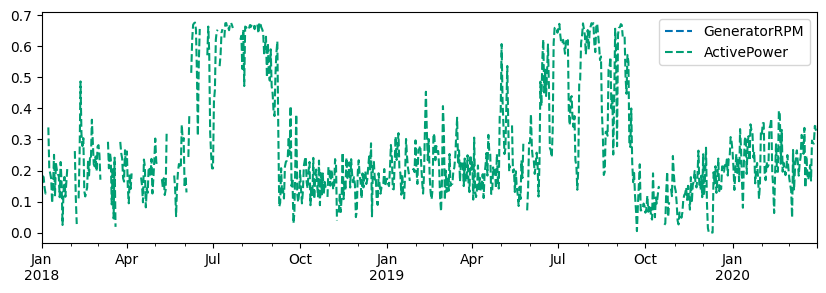

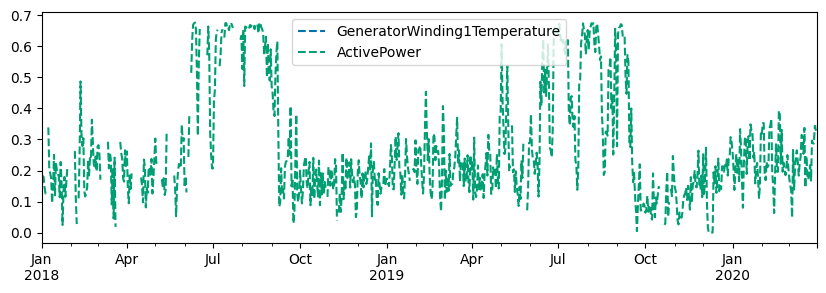

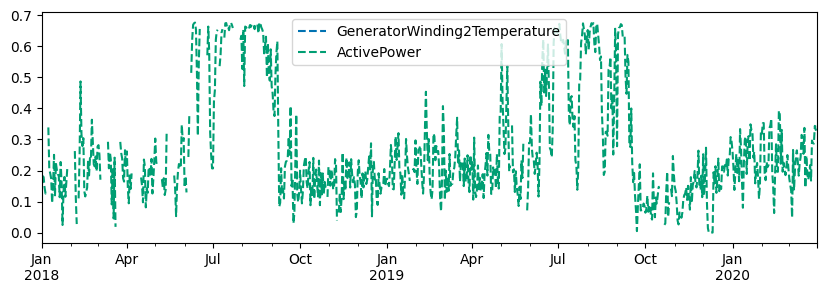

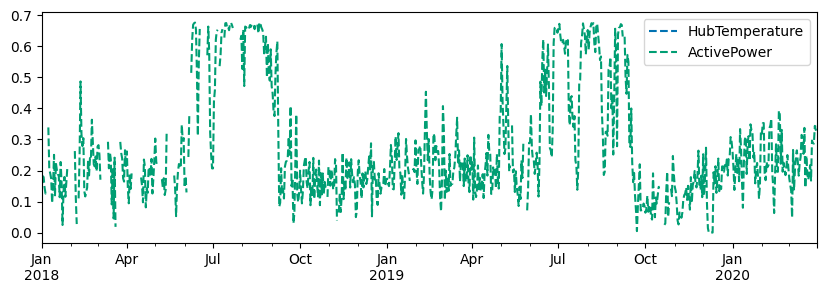

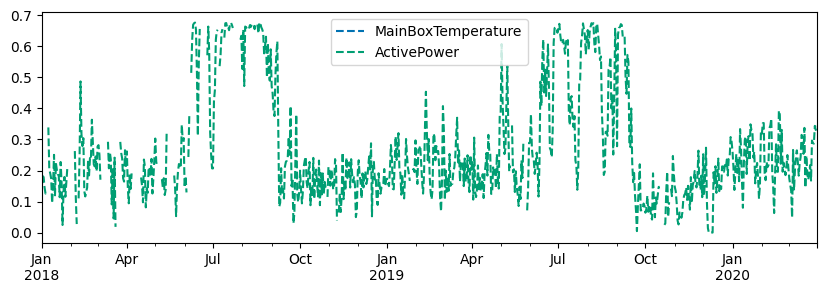

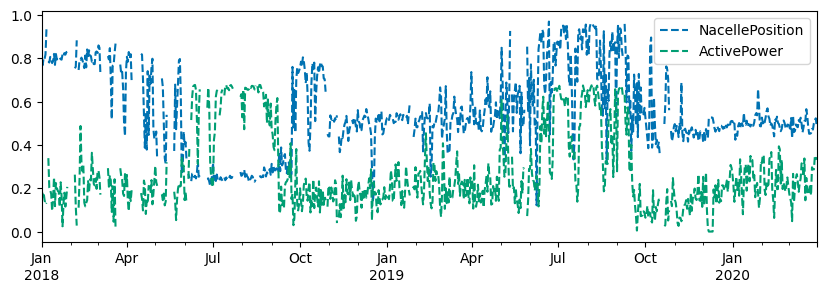

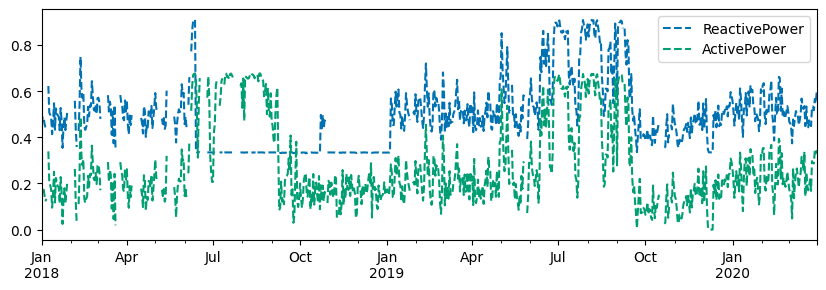

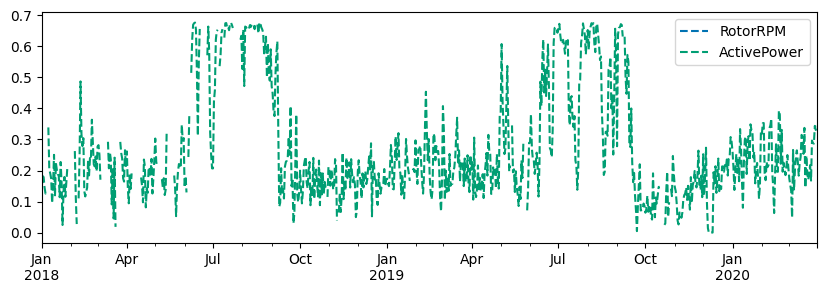

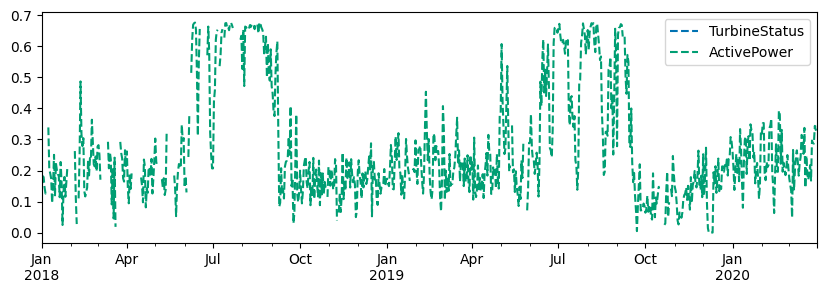

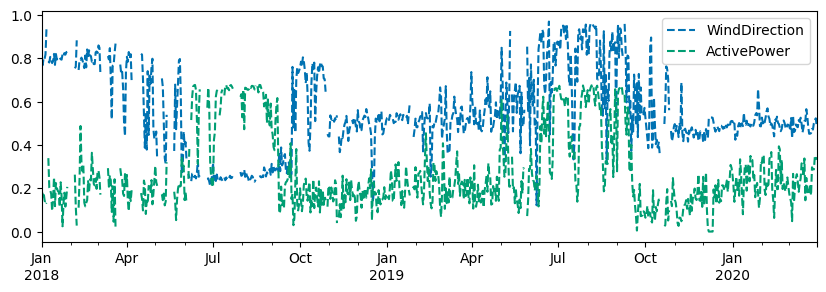

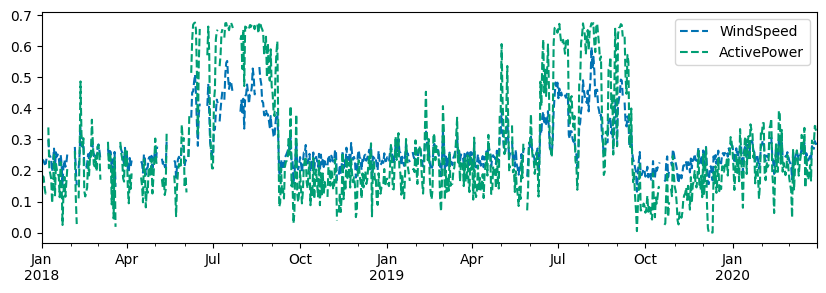

In [155]:
#visualization
data2 = data.copy()
for column in data:
    min_value = min(data[column])
    max_value = max(data[column])
    data2[column] = (data2[column]- min_value)/(max_value-min_value)
    
    plt.figure(figsize=(10,3))
    #sampling the data in days 
    data2[column].resample('D').mean().plot(legend=column, linestyle="dashed")
    (data2['ActivePower']*0.7).resample('D').mean().plot(kind="line", linestyle="dashed", legend='ActivePower')
    plt.legend()
    plt.show()

There appears to be a good correlation between the windspeed and active power.

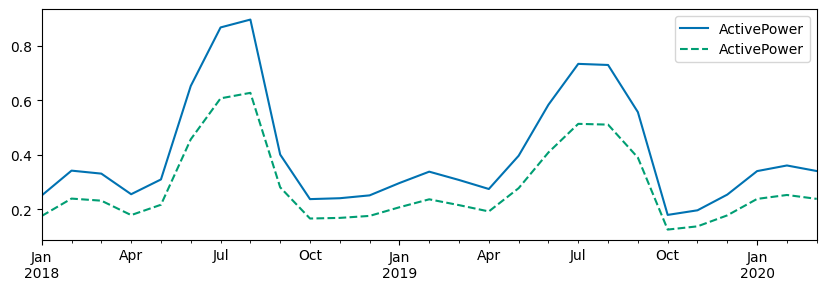

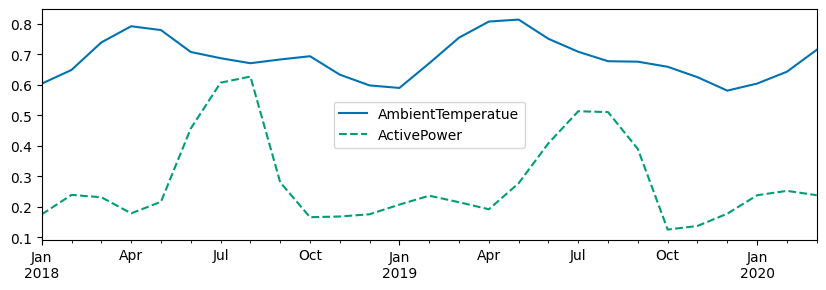

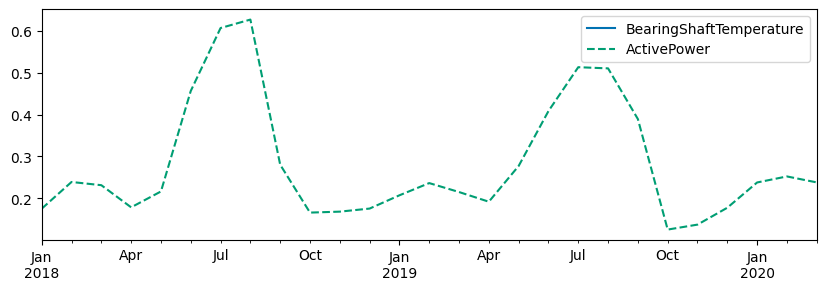

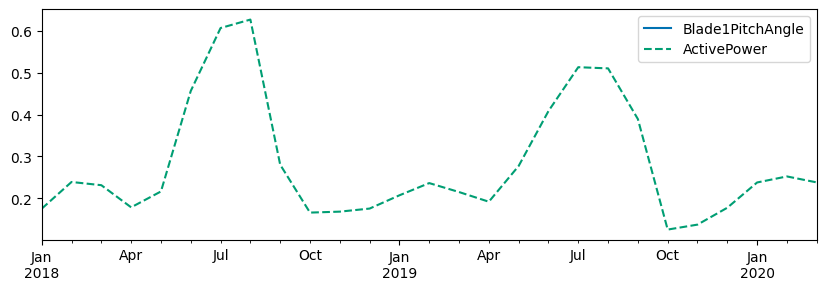

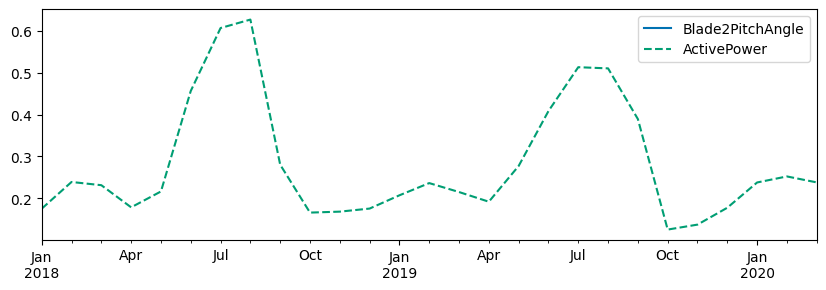

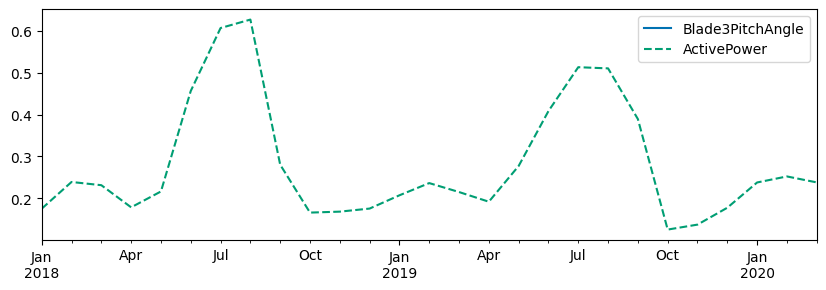

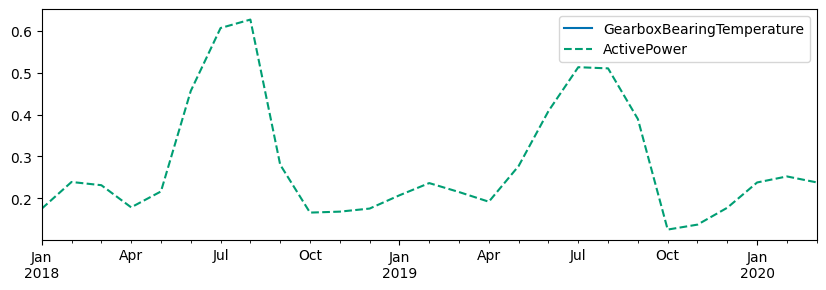

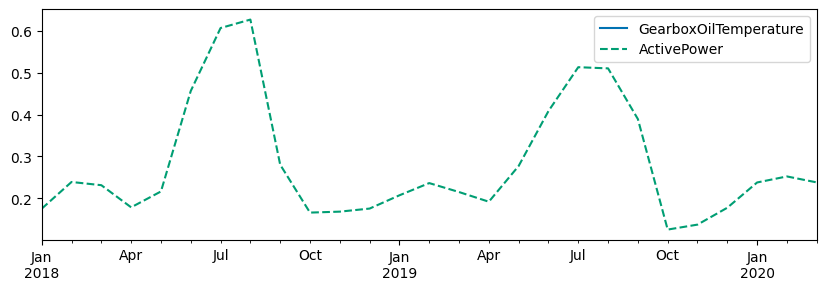

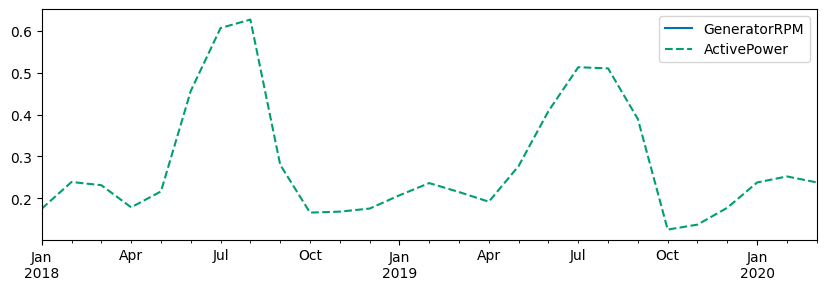

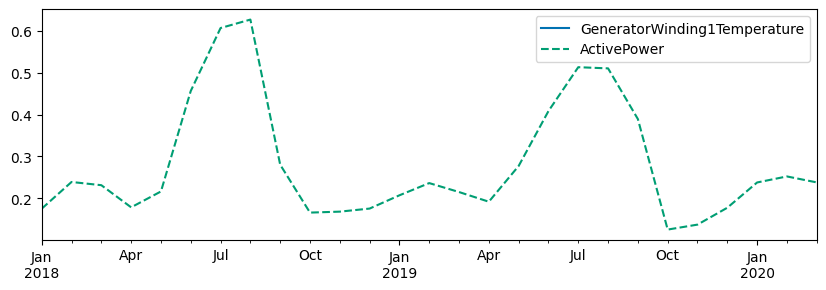

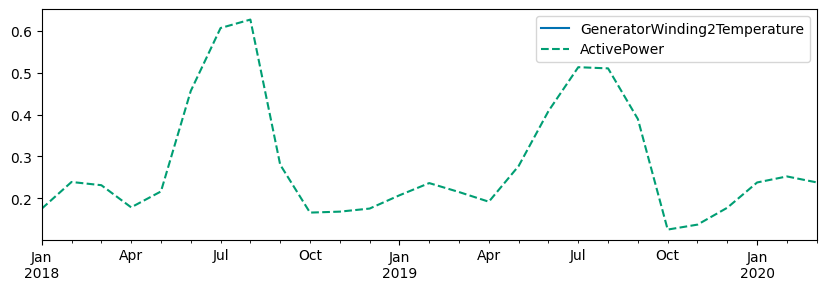

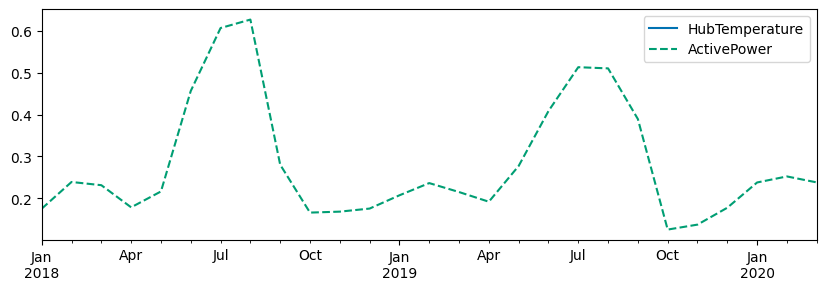

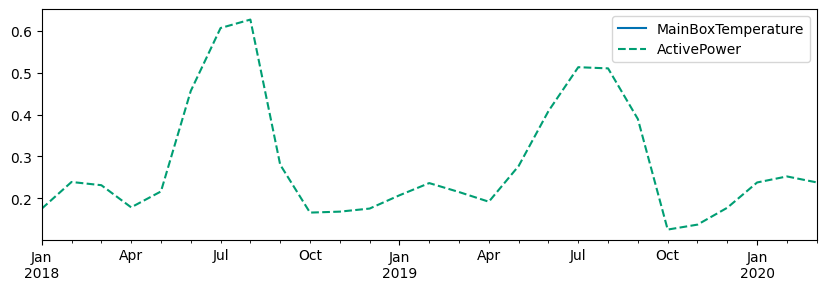

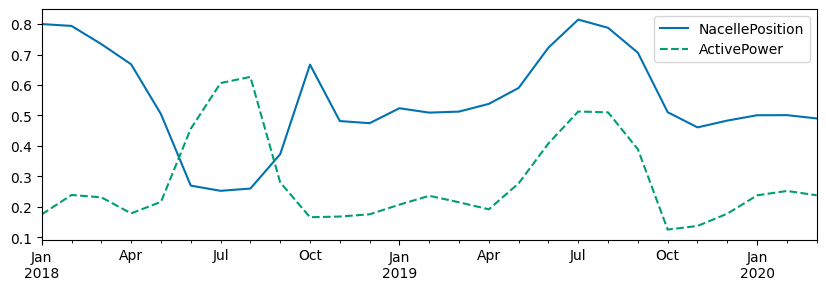

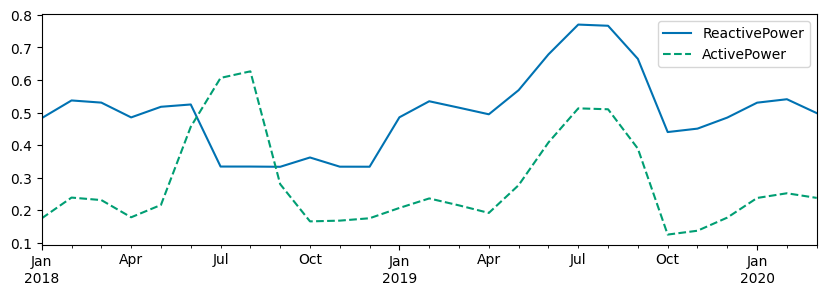

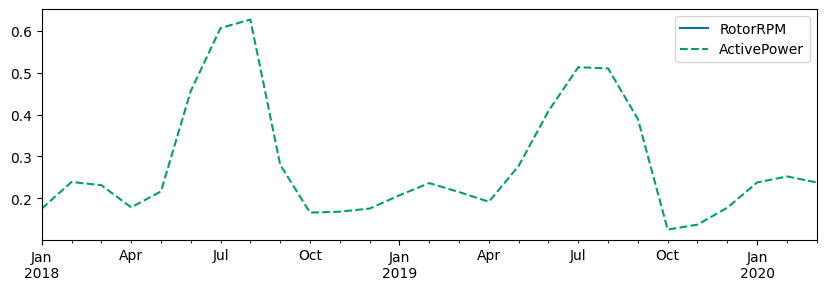

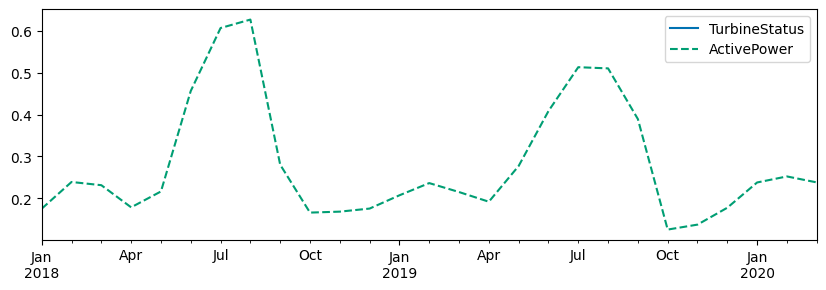

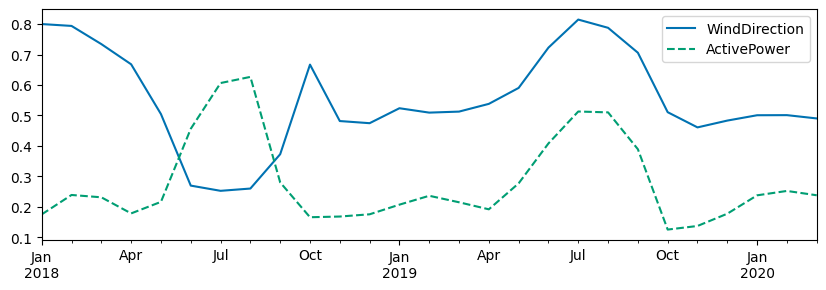

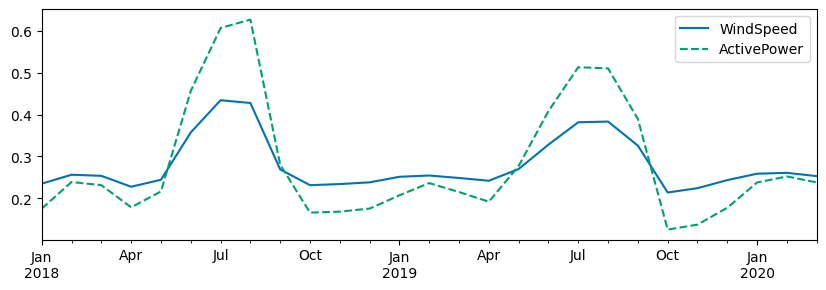

In [156]:
#sampling the data in days
for column in data:
    
    plt.figure(figsize=(10,3))
    data2[column].resample('M').mean().plot(kind="line", legend=column)
    (data2['ActivePower']*0.7).resample('M').mean().plot(kind="line", linestyle='dashed', legend='ActivePower')
    plt.legend()
    plt.show()

<h3> Exploratory Data Analysis</h3>

<h4>Correlations</h4>

<Axes: >

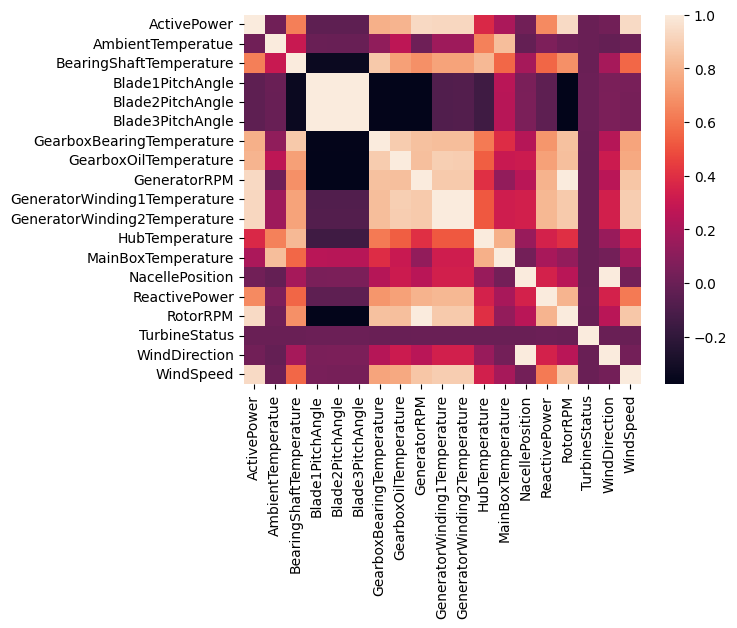

In [157]:
sns.heatmap(data.corr())

<h3> Feature Engineering</h3>

In [158]:
correlations = data.corr().unstack().sort_values(ascending=False)

correlations['ActivePower']

ActivePower                     1.000000
WindSpeed                       0.937870
RotorRPM                        0.935928
GeneratorRPM                    0.934303
GeneratorWinding2Temperature    0.928769
GeneratorWinding1Temperature    0.927517
GearboxOilTemperature           0.801319
GearboxBearingTemperature       0.786150
ReactivePower                   0.662808
BearingShaftTemperature         0.631922
HubTemperature                  0.372788
MainBoxTemperature              0.207514
NacellePosition                 0.024547
WindDirection                   0.024547
AmbientTemperatue               0.019064
TurbineStatus                  -0.001115
Blade1PitchAngle               -0.042637
Blade3PitchAngle               -0.042700
Blade2PitchAngle               -0.042700
dtype: float64

In [171]:
data = data[["ActivePower", "WindSpeed"]]
data.head()

,ActivePower,WindSpeed
2018-01-01 06:20:00+00:00,26.212347,3.042750
2018-01-01 06:40:00+00:00,59.632658,3.424814
2018-01-01 06:50:00+00:00,40.889650,3.507172
2018-01-01 10:40:00+00:00,34.398111,3.442212
2018-01-01 12:00:00+00:00,29.797653,3.031363


In [173]:
data.isnull().sum()

ActivePower      0
WindSpeed      308
dtype: int64

In [203]:
data.dropna(inplace=True)
data.isnull().sum()

ActivePower    0
WindSpeed      0
dtype: int64

In [209]:
data.shape

(78681, 2)

In [210]:
X = data["WindSpeed"]
Y = data["ActivePower"]

In [232]:
#splitting the data into testing and training sets
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5, test_size=900, max_train_size=77500)

all_splits = list(tscv.split(X,Y))

2020-02-28 06:20:00+00:00    6.072716
2020-02-28 06:30:00+00:00    5.272472
2020-02-28 06:40:00+00:00    4.450047
2020-02-28 06:50:00+00:00    4.424905
2020-02-28 07:00:00+00:00    5.231021
                               ...   
2020-03-08 05:40:00+00:00    3.814400
2020-03-08 05:50:00+00:00    3.289421
2020-03-08 06:00:00+00:00    3.995655
2020-03-08 06:10:00+00:00    3.824410
2020-03-08 06:20:00+00:00    4.726900
Name: WindSpeed, Length: 900, dtype: float64

In [253]:
train_0, test_0 = all_splits[0]
train_1, test_1 = all_splits[1]
train_2, test_2 = all_splits[2]
train_3, test_3 = all_splits[3]
train_4, test_4 = all_splits[4]

2018-01-01 06:20:00+00:00    3.042750
2018-01-01 06:40:00+00:00    3.424814
2018-01-01 06:50:00+00:00    3.507172
2018-01-01 10:40:00+00:00    3.442212
2018-01-01 12:00:00+00:00    3.031363
                               ...   
2020-02-20 20:40:00+00:00    6.737705
2020-02-20 20:50:00+00:00    6.709478
2020-02-20 21:00:00+00:00    7.317115
2020-02-20 21:10:00+00:00    6.852568
2020-02-20 21:20:00+00:00    7.260179
Name: WindSpeed, Length: 74181, dtype: float64

<h2 id="modeling">
  Modeling
</h2>

<h3> Gradient Boosting</h3>

In [224]:
model = xgb.XGBRegressor(n_estimators = 200, early_stopping_rounds=50)

In [262]:
model.fit(X.iloc[train_2], Y.iloc[train_2], eval_set=[(X.iloc[train_2], Y.iloc[train_2]), (X.iloc[test_2], Y.iloc[test_2])], verbose=True)

[0]	validation_0-rmse:421.17219	validation_1-rmse:402.05337
[1]	validation_0-rmse:300.72312	validation_1-rmse:288.91948
[2]	validation_0-rmse:218.63654	validation_1-rmse:211.17766
[3]	validation_0-rmse:164.00871	validation_1-rmse:158.86422
[4]	validation_0-rmse:129.03695	validation_1-rmse:124.46951
[5]	validation_0-rmse:107.82117	validation_1-rmse:102.65267
[6]	validation_0-rmse:95.71478	validation_1-rmse:89.37400
[7]	validation_0-rmse:89.17937	validation_1-rmse:81.56312
[8]	validation_0-rmse:85.79059	validation_1-rmse:77.05032
[9]	validation_0-rmse:84.07909	validation_1-rmse:74.46096
[10]	validation_0-rmse:83.22447	validation_1-rmse:72.95728
[11]	validation_0-rmse:82.80274	validation_1-rmse:72.06340
[12]	validation_0-rmse:82.59355	validation_1-rmse:71.52398
[13]	validation_0-rmse:82.49099	validation_1-rmse:71.18305
[14]	validation_0-rmse:82.43967	validation_1-rmse:70.96444
[15]	validation_0-rmse:82.41404	validation_1-rmse:70.82627
[16]	validation_0-rmse:82.40136	validation_1-rmse:70.7

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [263]:
pred = model.predict(X.iloc[test_2])

In [264]:
df_final = pd.DataFrame(data={'Actuals': Y.iloc[test_2], 'Predictions': pred})

<h2 id="evaluation">
  Evaluation
</h2>

In [268]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error

print('The Coefficient of determination (R-squared) = {:.3f}'.format(r2_score(df_final['Actuals'],df_final['Predictions'])))
print('The mean absolute error (MAE)                = {:.2f}'.format(mean_absolute_error(df_final['Actuals'],df_final['Predictions'])))
print('The RMSE error (RMSE)                        = {:.2f}'.format(root_mean_squared_error(df_final['Actuals'],df_final['Predictions'])))
print('The Mean absolute percentage error (MAPE)    = {:.3f}'.format(mean_absolute_percentage_error(df_final['Actuals'],df_final['Predictions'])))  


The Coefficient of determination (R-squared) = 0.984
The mean absolute error (MAE)                = 50.79
The RMSE error (RMSE)                        = 70.54
The Mean absolute percentage error (MAPE)    = 0.394


<h2 id="results">
  Result and Insights
</h2>

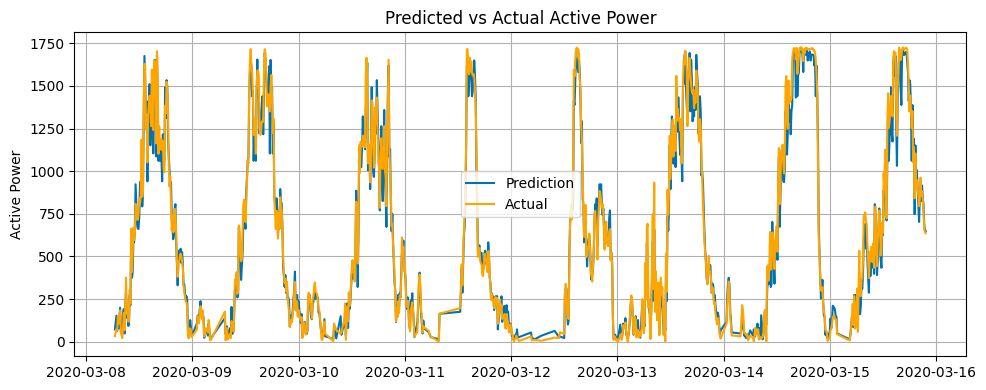

In [269]:
#visualization

plt.figure(figsize=(10,4))
plt.plot(df_final['Predictions'],label='Prediction')
plt.plot(df_final['Actuals'], color='orange',label='Actual')

plt.ylabel('Active Power')
plt.legend()
plt.title("Predicted vs Actual Active Power")
plt.tight_layout()
plt.grid()
plt.show()

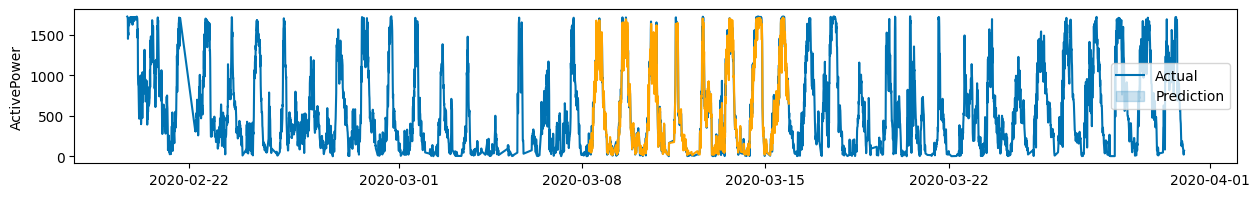

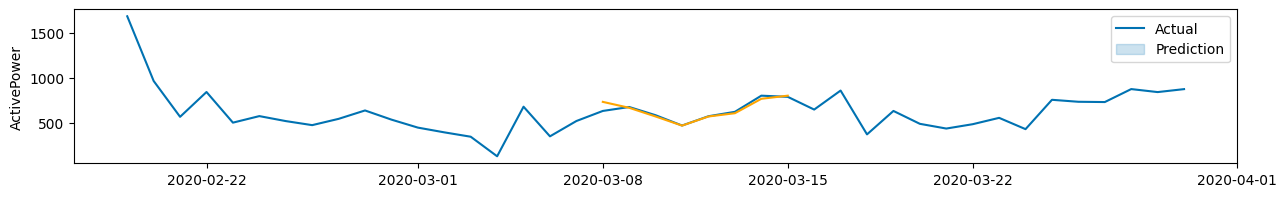

In [273]:
plt.figure(figsize=(15,2))
sns.lineplot(data = data["ActivePower"][74000:])
sns.lineplot(data = df_final['Predictions'], color="orange")
plt.legend(["Actual", "Prediction"])

plt.figure(figsize=(15,2))
sns.lineplot(data = data["ActivePower"][74000:].resample('D').mean())
sns.lineplot(data = df_final['Predictions'].resample('D').mean(), color="orange")
plt.legend(["Actual", "Prediction"])

<h3>New model trained on new Features for prediction</h3>

In [274]:
data.tail()

,ActivePower,WindSpeed
2020-03-30 23:10:00+00:00,70.044465,3.533445
2020-03-30 23:20:00+00:00,40.833474,3.261231
2020-03-30 23:30:00+00:00,20.777790,3.331839
2020-03-30 23:40:00+00:00,62.091039,3.284468
2020-03-30 23:50:00+00:00,68.664425,3.475205


As shown above, the last date above is 30th of March 2020. 

In [276]:
#Creating a dataset with a new datarange

new_df = pd.date_range("2020-04-01 12:00:00+00:00", "2020-06-01 12:00:00+00:00", freq="10min")

new_df = pd.DataFrame(index=new_df)

In [277]:
new_df.shape

(8785, 0)

In [278]:
#generating new feature values from `Pandas' datatime

def gen_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week
        
    return df
    

In [279]:
data2 = data.copy()
data2 = gen_features(data2)
data2.head()

,ActivePower,WindSpeed,hour,minute,day,month,year,dayofweek,dayofyear,weekofyear
2018-01-01 06:20:00+00:00,26.212347,3.042750,6,20,1,1,2018,0,1,1
2018-01-01 06:40:00+00:00,59.632658,3.424814,6,40,1,1,2018,0,1,1
2018-01-01 06:50:00+00:00,40.889650,3.507172,6,50,1,1,2018,0,1,1
2018-01-01 10:40:00+00:00,34.398111,3.442212,10,40,1,1,2018,0,1,1
2018-01-01 12:00:00+00:00,29.797653,3.031363,12,0,1,1,2018,0,1,1


In [309]:
data2.columns
data2.isnull().sum()
data2 = data2.dropna()

In [333]:
Y1 = data2["ActivePower"]
X1 = data2.drop(columns=["ActivePower", "WindSpeed"], axis=1)
Y1.head()

2018-01-01 06:20:00+00:00    26.212347
2018-01-01 06:40:00+00:00    59.632658
2018-01-01 06:50:00+00:00    40.889650
2018-01-01 10:40:00+00:00    34.398111
2018-01-01 12:00:00+00:00    29.797653
Name: ActivePower, dtype: float64

In [334]:
X1.head()

,hour,minute,day,month,year,dayofweek,dayofyear,weekofyear
2018-01-01 06:20:00+00:00,6,20,1,1,2018,0,1,1
2018-01-01 06:40:00+00:00,6,40,1,1,2018,0,1,1
2018-01-01 06:50:00+00:00,6,50,1,1,2018,0,1,1
2018-01-01 10:40:00+00:00,10,40,1,1,2018,0,1,1
2018-01-01 12:00:00+00:00,12,0,1,1,2018,0,1,1


In [335]:
tscv2 = TimeSeriesSplit(n_splits=5, test_size=900, max_train_size=77500)

all_splits = list(tscv.split(X1,Y1))

train_a, test_a = all_splits[0]
train_b, test_b = all_splits[1]
train_c, test_c = all_splits[2]
train_d, test_d = all_splits[3]
train_e, test_e = all_splits[4]

In [336]:
X1.iloc[test_b]

,hour,minute,day,month,year,dayofweek,dayofyear,weekofyear
2020-02-28 06:20:00+00:00,6,20,28,2,2020,4,59,9
2020-02-28 06:30:00+00:00,6,30,28,2,2020,4,59,9
2020-02-28 06:40:00+00:00,6,40,28,2,2020,4,59,9
2020-02-28 06:50:00+00:00,6,50,28,2,2020,4,59,9
2020-02-28 07:00:00+00:00,7,0,28,2,2020,4,59,9
...,...,...,...,...,...,...,...,...
2020-03-08 05:40:00+00:00,5,40,8,3,2020,6,68,10
2020-03-08 05:50:00+00:00,5,50,8,3,2020,6,68,10
2020-03-08 06:00:00+00:00,6,0,8,3,2020,6,68,10
2020-03-08 06:10:00+00:00,6,10,8,3,2020,6,68,10


In [337]:
model2 = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, early_stopping_rounds=50)
model2.fit(X1.iloc[train_b], Y1.iloc[train_b], eval_set=[(X1.iloc[train_b], Y1.iloc[train_b]), (X1.iloc[test_b], Y1.iloc[test_b])], verbose=True)

[0]	validation_0-rmse:592.71408	validation_1-rmse:546.74132
[1]	validation_0-rmse:589.37787	validation_1-rmse:544.49777
[2]	validation_0-rmse:586.08931	validation_1-rmse:542.26246
[3]	validation_0-rmse:582.84476	validation_1-rmse:539.91604
[4]	validation_0-rmse:579.62567	validation_1-rmse:537.60362
[5]	validation_0-rmse:576.48631	validation_1-rmse:535.35762
[6]	validation_0-rmse:573.37937	validation_1-rmse:533.11187
[7]	validation_0-rmse:570.32721	validation_1-rmse:531.01033
[8]	validation_0-rmse:567.30787	validation_1-rmse:528.85719
[9]	validation_0-rmse:564.34486	validation_1-rmse:526.72195
[10]	validation_0-rmse:561.39077	validation_1-rmse:524.62765
[11]	validation_0-rmse:558.53029	validation_1-rmse:522.63608
[12]	validation_0-rmse:555.68189	validation_1-rmse:520.60195
[13]	validation_0-rmse:552.86599	validation_1-rmse:518.66399
[14]	validation_0-rmse:550.11294	validation_1-rmse:516.63730
[15]	validation_0-rmse:547.38765	validation_1-rmse:514.73108
[16]	validation_0-rmse:544.70581	v

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [338]:
pred1 = model2.predict(X1.iloc[test_b])

In [339]:
df_final1 = pd.DataFrame(data={'Actuals': Y1.iloc[test_b], 'Predictions': pred1})

df_final1

,Actuals,Predictions
2020-02-28 06:20:00+00:00,581.183157,295.993408
2020-02-28 06:30:00+00:00,412.662178,295.993408
2020-02-28 06:40:00+00:00,214.307887,295.993408
2020-02-28 06:50:00+00:00,258.512535,295.993408
2020-02-28 07:00:00+00:00,431.106120,313.793457
...,...,...
2020-03-08 05:40:00+00:00,91.501797,302.002594
2020-03-08 05:50:00+00:00,57.368291,302.002594
2020-03-08 06:00:00+00:00,104.782013,302.002594
2020-03-08 06:10:00+00:00,128.669171,302.002594


In [340]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error

print('The Coefficient of determination (R-squared) = {:.3f}'.format(r2_score(df_final1['Actuals'],df_final1['Predictions'])))
print('The mean absolute error (MAE)                = {:.2f}'.format(mean_absolute_error(df_final1['Actuals'],df_final1['Predictions'])))
print('The RMSE error (RMSE)                        = {:.2f}'.format(root_mean_squared_error(df_final1['Actuals'],df_final1['Predictions'])))
print('The Mean absolute percentage error (MAPE)    = {:.3f}'.format(mean_absolute_percentage_error(df_final1['Actuals'],df_final1['Predictions'])))  


The Coefficient of determination (R-squared) = 0.329
The mean absolute error (MAE)                = 316.34
The RMSE error (RMSE)                        = 384.33
The Mean absolute percentage error (MAPE)    = 10.277


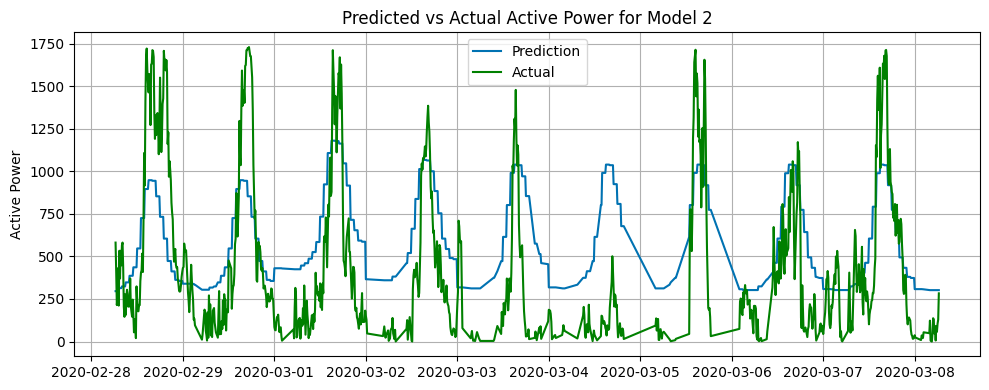

In [341]:
#visualization

plt.figure(figsize=(10,4))
plt.plot(df_final1['Predictions'],label='Prediction')
plt.plot(df_final1['Actuals'], color='green',label='Actual')

plt.ylabel('Active Power')
plt.legend()
plt.title("Predicted vs Actual Active Power for Model 2")
plt.tight_layout()
plt.grid()
plt.show()

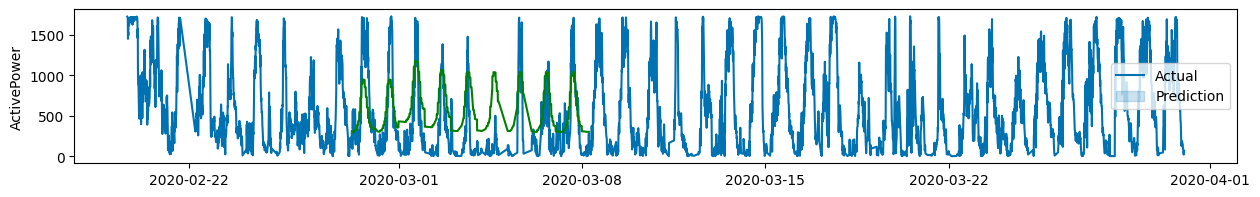

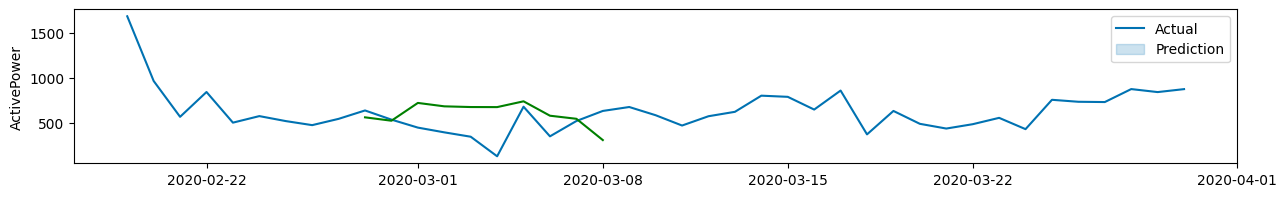

In [342]:
plt.figure(figsize=(15,2))
sns.lineplot(data = data2["ActivePower"][74000:])
sns.lineplot(data = df_final1['Predictions'], color="green")
plt.legend(["Actual", "Prediction"])

plt.figure(figsize=(15,2))
sns.lineplot(data = data2["ActivePower"][74000:].resample('D').mean())
sns.lineplot(data = df_final1['Predictions'].resample('D').mean(), color="green")
plt.legend(["Actual", "Prediction"])

<h2 id="conclusions">
  Conclusions
</h2>

In [347]:
#Saving the model
import pickle
file_name = "model2.pkl"
pickle.dump(model2, open(file_name, "wb"))

<h3>Author: <a href="mailto:mnnamchi@gmail.com">Martins Nnamchi</a></h3>